In [4]:

! curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  8496k      0  0:00:14  0:00:14 --:--:-- 10.7M    0  1007k      0  0:02:01  0:00:02  0:01:59 1396k


In [67]:
from PIL import Image
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np

# Load the dataset
dataset_path = 'reverse_image_search.csv'  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



In [68]:
embeddings = []

for index, row in df.iterrows():
    image_path = row['path']  # Assuming the path is in a column named 'path'
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB
    inputs = processor(images=image, return_tensors="pt")
    image_features = model.get_image_features(**inputs)
    # Ensure the tensor is detached from the computational graph before converting
    embedding = image_features.squeeze(0).detach().numpy().tolist()
    embedding = embedding/np.linalg.norm(embedding)
    embeddings.append(embedding)


In [7]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# Milvus parameters
HOST = '127.0.0.1'
PORT = '19530'
TOPK = 13

In [8]:
connections.connect(host=HOST, port=PORT)
dim = 512  # Dimension of the embeddings
METRIC_TYPE = 'L2'  # You can choose 'L2', 'IP', etc., based on your requirement
INDEX_TYPE = 'IVF_FLAT'  # Index type

In [36]:
def create_milvus_collection(collection_name):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
        FieldSchema(name='path', dtype=DataType.VARCHAR, description='path to image', max_length=500, 
                    is_primary=True, auto_id=False),
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        'metric_type': METRIC_TYPE,
        'index_type': INDEX_TYPE,
        'params': {"nlist": dim}
    }
    collection.create_index(field_name='embedding', index_params=index_params)
    return collection

In [40]:
utility.list_collections()

['text_image_search', 'tranformers_clip_patch16', 'default']

In [66]:
utility.drop_collection('default')

In [48]:
collection_name = "default_collection"
collection = create_milvus_collection(collection_name)



In [49]:
collection = create_milvus_collection(collection_name)

In [69]:
paths = df['path'].tolist()
entities = [[path for path in paths],
            [embedding for embedding in embeddings]]
#preparing for insertion to milvus

In [70]:
mr = collection.insert(entities)


In [71]:
collection = Collection(collection_name)      # Get an existing collection.
collection.load()


In [72]:
search_params = {
    "metric_type": "L2", 
    "offset": 0, 
    "ignore_growing": False, 
    "params": {"nprobe": 10}
}

In [73]:

# search with image

query_image_path = './test/Afghan_hound/n02088094_4261.JPEG'  
query_image = Image.open(query_image_path).convert('RGB')  
query_inputs = processor(images=query_image, return_tensors="pt")
query_image_features = model.get_image_features(**query_inputs)
embedding = query_image_features.squeeze(0).detach().numpy().tolist()


# Concatenate all feature vectors into a single tensor
#image_features_tensor = torch.stack(embeddings)

# image_features_tensor now contains the feature vectors for all images in your dataset

results = collection.search(
    data=[embedding], 
    anns_field="embedding", 
    # the sum of `offset` in `param` and `limit` 
    # should be less than 16384.
    param=search_params,
    limit=10,
    expr=None,
)



In [74]:
results[0].ids


['./train/Afghan_hound/n02088094_5911.JPEG',
 './train/Bouvier_des_Flandres/n02106382_6653.JPEG',
 './train/soft-coated_wheaten_terrier/n02098105_6619.JPEG',
 './train/Afghan_hound/n02088094_6533.JPEG',
 './train/soft-coated_wheaten_terrier/n02098105_2738.JPEG',
 './train/malamute/n02110063_13179.JPEG',
 './train/standard_poodle/n02113799_9150.JPEG',
 './train/standard_poodle/n02113799_671.JPEG',
 './train/standard_poodle/n02113799_9692.JPEG',
 './train/Doberman/n02107142_24759.JPEG']

In [80]:
results[0].distances

[1.4285924434661865,
 1.4338502883911133,
 1.4382538795471191,
 1.4401578903198242,
 1.4414832592010498,
 1.4459296464920044,
 1.4490365982055664,
 1.4498789310455322,
 1.4508565664291382,
 1.453905701637268]

In [134]:
# search with text 
#patch 16
query_text = "cat on shower"  
text_inputs = processor(text=query_text, return_tensors="pt")
query_text_features = model.get_text_features(**text_inputs)
text_embedding = query_text_features.squeeze(0).detach().numpy().tolist()


text_embedding = text_embedding/np.linalg.norm(text_embedding)


In [135]:
results = collection.search(
    data=[text_embedding], 
    anns_field="embedding", 
    # the sum of `offset` in `param` and `limit` 
    # should be less than 16384.
    param=search_params,
    limit=10,
    expr=None,
)



In [136]:
tresholded_list= []
tresholded_ids= []
tresholded_distances= []
for i in range(len(results[0].ids)):
    if(results[0].distances[i]<1.5):
        tresholded_list.append(results[0][i])
        tresholded_ids.append(results[0].ids[i])
        tresholded_distances.append(results[0].distances[i])

        


In [137]:
results[0].ids


['./train/tub/n04493381_4746.JPEG',
 './train/remote_control/n04074963_2858.JPEG',
 './train/dishwasher/n03207941_13200.JPEG',
 './train/dishwasher/n03207941_436.JPEG',
 './train/toilet_seat/n04447861_6808.JPEG',
 './train/goldfish/n01443537_6743.JPEG',
 './train/barn_spider/n01773549_6399.JPEG',
 './train/tub/n04493381_42891.JPEG',
 './train/safety_pin/n04127249_10227.JPEG',
 './train/toilet_seat/n04447861_6480.JPEG']

In [138]:
results[0].distances

[1.4342446327209473,
 1.4872307777404785,
 1.5372908115386963,
 1.545475959777832,
 1.5467710494995117,
 1.5546222925186157,
 1.555027961730957,
 1.5596531629562378,
 1.5649840831756592,
 1.5659137964248657]

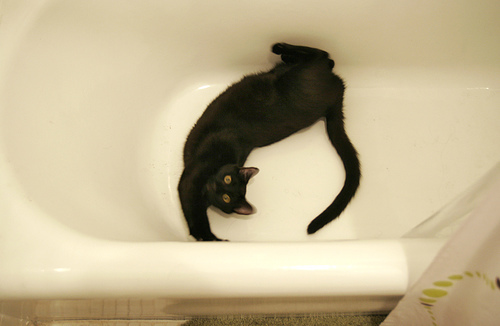

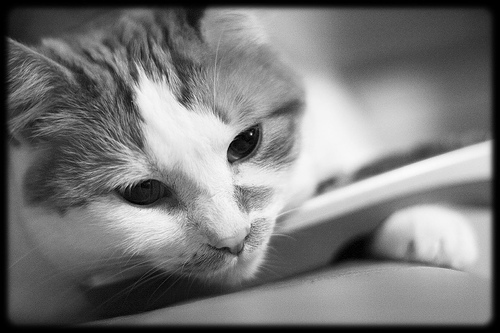

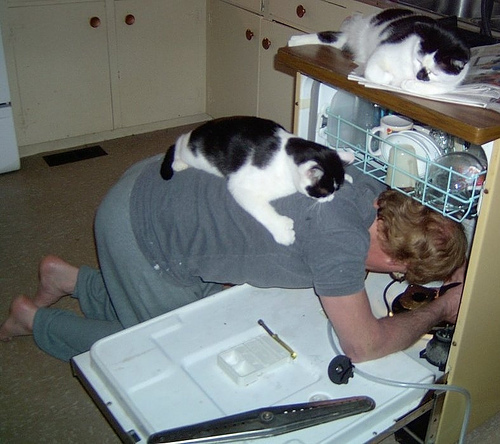

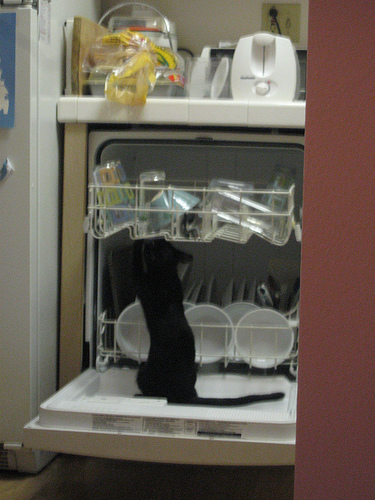

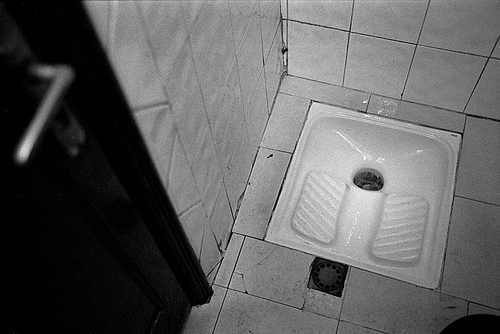

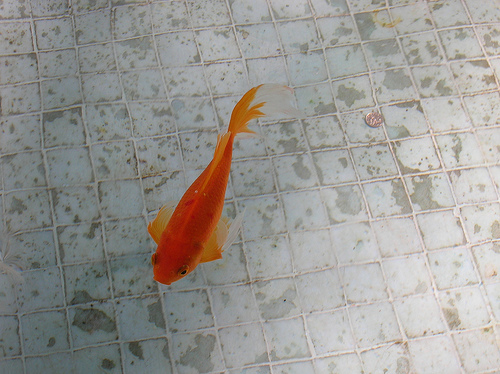

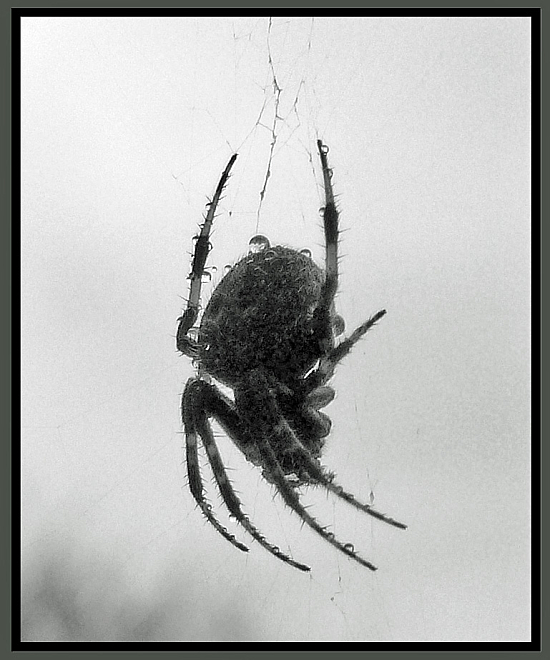

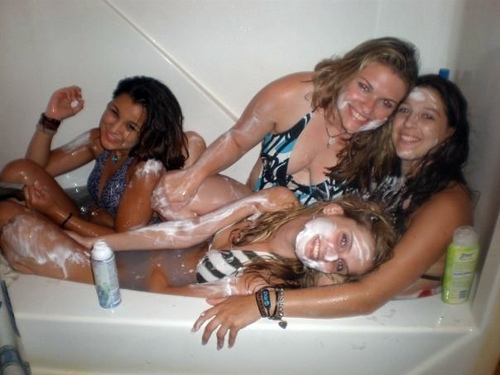

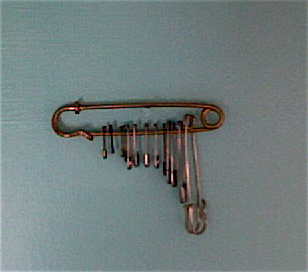

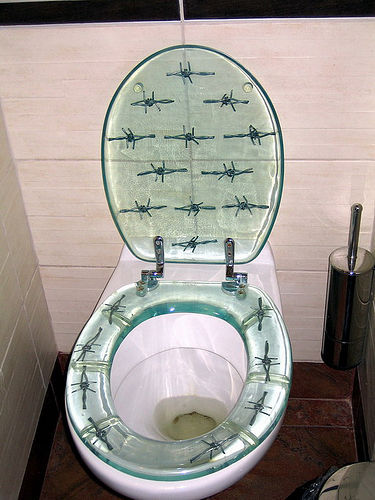

In [143]:
from IPython.display import Image
for img in results[0].ids:
    # Display the image
    display(Image(filename=img))


In [132]:
tresholded_list

[id: ./train/bottlecap/n02877765_3458.JPEG, distance: 1.4671523571014404, entity: {},
 id: ./train/bottlecap/n02877765_8325.JPEG, distance: 1.4687036275863647, entity: {},
 id: ./train/jean/n03594734_9714.JPEG, distance: 1.4873895645141602, entity: {},
 id: ./train/magpie/n01582220_4738.JPEG, distance: 1.4912283420562744, entity: {}]

In [133]:
tresholded_ids

['./train/bottlecap/n02877765_3458.JPEG',
 './train/bottlecap/n02877765_8325.JPEG',
 './train/jean/n03594734_9714.JPEG',
 './train/magpie/n01582220_4738.JPEG']

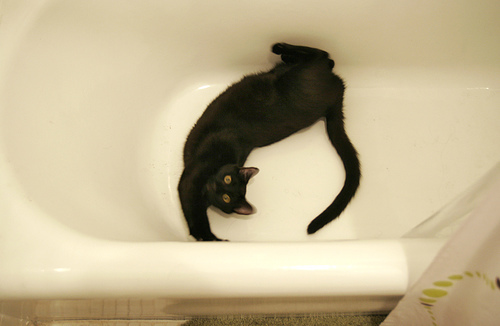

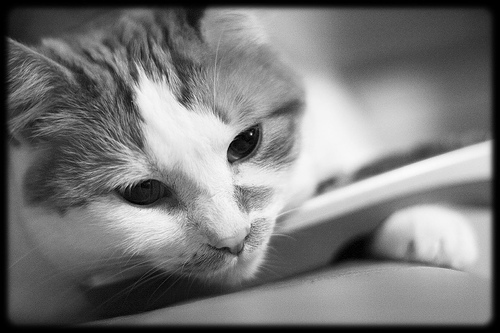

In [145]:
from IPython.display import Image
for img in tresholded_ids:
    # Display the image
    display(Image(filename=img))
